### Task is to get group quarter data from both decennial and ACS-5 year data at tract level and compare the two. ACS uses a sampling frame, whereas decennial is more complete. This notebooks compares data from ACS2013-2017, ACS2011-2015, and 2020 PL 94-171 data.


#### 1. Setting the environment

In [1]:
!pip install census
!pip install us
!pip install geopandas
!pip install contextily

In [76]:
from census import Census
from us import states
import json 
import pandas as pd
from urllib.request import urlopen
import urllib.error
import matplotlib
import geopandas as gpd
from IPython.display import display
import matplotlib.pyplot as plt
import contextily as cx

#### 2. Setting the API call variables

In [77]:
key = '3dd3875d2478da2c2bb0825c62d395846493d805'

#Table B26101: Group Quarters Type (3 Types) by Sex by Age
#getting both estimates and margin of error
get = 'NAME,B01001_034E,B01001_034M'
geo1 = 'tract:*'
geo2 = 'state:06'

#ACS 5-year list
years = [2015, 2017]
acs = 'acs5'

#bay area county list
bac = ['001','013','041','055','075','081','085','095','097']

#### 3. Running the API call for both ACS tables and the DC table

In [78]:
#read both ACS files and combinbe

gq_acs5 = pd.DataFrame()
for year in years:
    path = 'http://api.census.gov/data/%d/acs/%s?get=%s&for=%s&in=%s&key=%s'% (year,acs, get, geo1, geo2,key)
    try:
        data = urllib.request.urlopen(path).read()
        data_json = json.loads(data)
        df = pd.DataFrame(data_json[1:], columns=data_json[0])
        df.rename({'B01001_034E': 'GQPOP', 'B01001_034M': 'GQPOP_ME'}, axis=1, inplace=True)
        df['year'] = year
        df = df.loc[df['county'].isin(bac)]
        gq_acs5 = gq_acs5.append(df,ignore_index = True)
        
    except urllib.error.HTTPError:
        gq_acs5 = gq_acs5

In [79]:
path

'http://api.census.gov/data/2017/acs/acs5?get=NAME,B01001_034E,B01001_034M&for=tract:*&in=state:06&key=3dd3875d2478da2c2bb0825c62d395846493d805'

In [80]:
gq_acs5.head()

NAME GQPOP GQPOP_ME state  \
0  Census Tract 4515.03, Alameda County, California    54       86    06   
1     Census Tract 4093, Alameda County, California   195      113    06   
2     Census Tract 4097, Alameda County, California   129       66    06   
3     Census Tract 4513, Alameda County, California     0       17    06   
4     Census Tract 4024, Alameda County, California    70       75    06   

  county   tract  year  
0    001  451503  2015  
1    001  409300  2015  
2    001  409700  2015  
3    001  451300  2015  
4    001  402400  2015

In [81]:
#repeat the same for 2020 Decennial Census
gq_2020 = pd.DataFrame()

path = 'http://api.census.gov/data/2020/dec/pl?get=NAME,P5_001N&for=%s&in=%s&key=%s'% (geo1, geo2,key)
try:
    data = urllib.request.urlopen(path).read()
    data_json = json.loads(data)
    df = pd.DataFrame(data_json[1:], columns=data_json[0])
    df.rename({'P5_001N': 'GQPOP'}, axis=1, inplace=True)
    df['GQPOP_ME'] = 0
    df['year'] = 2020
    df = df.loc[df['county'].isin(bac)]
    gq_2020 = gq_2020.append(df,ignore_index = True)
        
except urllib.error.HTTPError:
    gq_2020 = gq_2020

In [82]:
gq_2020.head()

NAME GQPOP state county  \
0  Census Tract 3131.02, Contra Costa County, Cal...   307    06    013   
1  Census Tract 3131.04, Contra Costa County, Cal...    15    06    013   
2  Census Tract 3131.05, Contra Costa County, Cal...     6    06    013   
3  Census Tract 3131.06, Contra Costa County, Cal...    22    06    013   
4  Census Tract 3131.07, Contra Costa County, Cal...     0    06    013   

    tract  GQPOP_ME  year  
0  313102         0  2020  
1  313104         0  2020  
2  313105         0  2020  
3  313106         0  2020  
4  313107         0  2020

In [83]:
#doing a quick check of number of tracts by county, as 2020 may have census tract boundary change
len(gq_acs5.loc[gq_acs5['year']==2015]) - len(gq_2020) == 0

False

In [84]:
gq = gq_acs5.append(gq_2020,ignore_index = True)

<AxesSubplot:xlabel='county'>

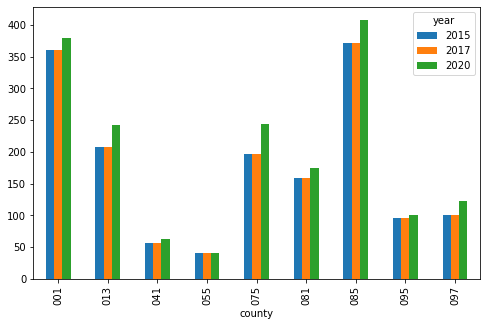

In [85]:
#examine the count of census tracts
ct_count = gq.groupby(['county','year'])['NAME'].size().to_frame(name = 'count').reset_index()
ct_count_wide = pd.pivot(ct_count, index =['county'], columns = 'year', values = 'count')
ct_count_wide.plot(kind = 'bar', figsize = (8, 5))

#### Findings: Except Napa County, every county in the Bay Area have an increase number of census tracts

In [86]:
#examine group quarter total by year
gq['GQPOP'] = pd.to_numeric(gq['GQPOP'])
gq['GQPOP_ME'] = pd.to_numeric(gq['GQPOP_ME'])
gq.groupby(['year'])['GQPOP'].sum()

year
2015    142253
2017    146599
2020    174857
Name: GQPOP, dtype: int64

In [87]:
#examine group quarter total by county
gq['GQPOP'] = pd.to_numeric(gq['GQPOP'])
gq['GQPOP_ME'] = pd.to_numeric(gq['GQPOP_ME'])
gq.groupby(['county','year'])['GQPOP'].sum()

county  year
001     2015    33049
        2017    32449
        2020    53833
013     2015    19945
        2017    20760
        2020    11255
041     2015     2931
        2017     3630
        2020     7743
055     2015     2419
        2017     2655
        2020     5172
075     2015    18947
        2017    18481
        2020    27892
081     2015    12446
        2017    13813
        2020     9352
085     2015    35112
        2017    36885
        2020    39607
095     2015     8726
        2017     8832
        2020    11137
097     2015     8678
        2017     9094
        2020     8866
Name: GQPOP, dtype: int64

##### Findings: group quarter sum looks very different for 2020, making a chart to visualize it.

<AxesSubplot:xlabel='county'>

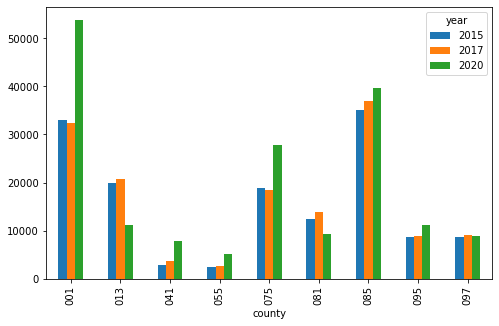

In [88]:
#visualize county group quarter pop totals
ct_gq = gq.groupby(['county','year'])['GQPOP'].sum().to_frame(name = 'sum').reset_index()
ct_gq_wide = pd.pivot(ct_gq, index =['county'], columns = 'year', values = 'sum')
ct_gq_wide.plot(kind = 'bar', figsize = (8, 5))

#### Findings: Alameda, Contra Costa, Napa, SF differ significantly. 

<AxesSubplot:xlabel='county'>

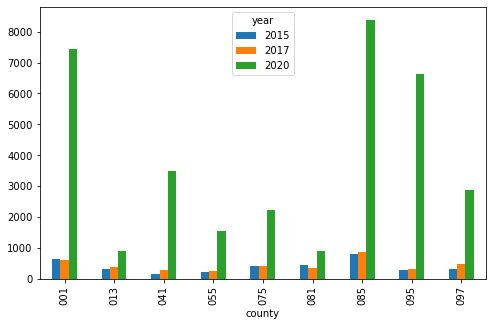

In [89]:
#visualize county group quarter pop max
ct_gq = gq.groupby(['county','year'])['GQPOP'].max().to_frame(name = 'max').reset_index()
ct_gq_wide = pd.pivot(ct_gq, index =['county'], columns = 'year', values = 'max')
ct_gq_wide.plot(kind = 'bar', figsize = (8, 5))

#### 4. mapping group quarters population, frst ACS data, then 2020 Decennial, because the census tracts are different

In [90]:
# These help the maps display nicely in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 20]

In [91]:
BA_tracts = gpd.read_file('M:/Data/Census/Geography/tl_2017_06_tract/tl_2017_06_tract_9CountyBayArea.shp')
BA_tracts.head()

STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  MTFCC  \
0      06      001  442700  06001442700     4427     Census Tract 4427  G5020   
1      06      001  442800  06001442800     4428     Census Tract 4428  G5020   
2      06      001  442900  06001442900     4429     Census Tract 4429  G5020   
3      06      001  443001  06001443001  4430.01  Census Tract 4430.01  G5020   
4      06      001  443002  06001443002  4430.02  Census Tract 4430.02  G5020   

  FUNCSTAT      ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  1234034.0     0.0  +37.5371514  -122.0081094   
1        S  1278647.0     0.0  +37.5293619  -121.9931002   
2        S  2066524.0     0.0  +37.5184093  -121.9748369   
3        S   768730.0     0.0  +37.5184218  -121.9515237   
4        S  1580323.0     0.0  +37.5168344  -121.9605916   

              longGEOID                                           geometry  
0  1400000US06001442700  POLYGON ((-122.01721 37.53932, -122.01719 37.5...  
1  1400000US06001442800  POLYGON ((-122.00230 37.52984, -122.00224 37.5...  
2  1400000US06001442900  POLYGON ((-121.98773 37.52248, -121.98765 37.5...  
3  1400000US06001443001  POLYGON ((-121.95760 37.52392, -121.95745 37.5...  
4  1400000US06001443002  POLYGON ((-121.96900 37.52248, -121.96885 37.5...

In [92]:
#keep necessary columns
BA_tracts = BA_tracts[['GEOID','geometry']]

In [93]:
#create a merging column
gq_acs5['merge_geoid'] = gq_acs5['state'].astype(str)+ gq_acs5['county'].astype(str)+ gq_acs5['tract'].astype(str)
gq_acs5 = gq_acs5[['GQPOP','GQPOP_ME','year','merge_geoid']]
gq_acs5.head()

GQPOP GQPOP_ME  year  merge_geoid
0    54       86  2015  06001451503
1   195      113  2015  06001409300
2   129       66  2015  06001409700
3     0       17  2015  06001451300
4    70       75  2015  06001402400

In [94]:
gq_acs5.describe(include = 'all')

GQPOP GQPOP_ME         year  merge_geoid
count   3176     3176  3176.000000         3176
unique   321      206          NaN         1588
top        0       12          NaN  06095252202
freq      87       81          NaN            2
mean     NaN      NaN  2016.000000          NaN
std      NaN      NaN     1.000157          NaN
min      NaN      NaN  2015.000000          NaN
25%      NaN      NaN  2015.000000          NaN
50%      NaN      NaN  2016.000000          NaN
75%      NaN      NaN  2017.000000          NaN
max      NaN      NaN  2017.000000          NaN

In [95]:
#change GQPOP to numberics
gq_acs5['GQPOP'] = pd.to_numeric(gq_acs5['GQPOP'])
gq_acs5['GQPOP_ME'] = pd.to_numeric(gq_acs5['GQPOP_ME'])

#remove census tract where GQPOP is less than 1
gq_acs5 = gq_acs5.loc[gq_acs5['GQPOP'] > 1]

#create separate dataframes so that I can create columns for calculations
gq_acs5_2015 = gq_acs5.loc[gq_acs5['year'] == 2015].copy()
gq_acs5_2015.rename({'GQPOP': 'GQPOP_2015','GQPOP_ME': 'GQPOP_ME_2015'}, axis=1, inplace=True)
gq_acs5_2015 = gq_acs5_2015[['GQPOP_2015','GQPOP_ME_2015','merge_geoid']]

gq_acs5_2017 = gq_acs5.loc[gq_acs5['year'] == 2017].copy()
gq_acs5_2017.rename({'GQPOP': 'GQPOP_2017','GQPOP_ME': 'GQPOP_ME_2017'}, axis=1, inplace=True)
gq_acs5_2017 = gq_acs5_2017[['GQPOP_2017','GQPOP_ME_2017','merge_geoid']]

gq_acs5_reshape = gq_acs5_2015.merge(gq_acs5_2017, on = 'merge_geoid', how = 'left')

#merge with shapefile
gq_acs5_merge = BA_tracts.merge(gq_acs5_reshape, left_on = 'GEOID', 
                                right_on = 'merge_geoid', how = 'left').drop(['merge_geoid'], axis = 1)

gq_acs5_merge.head()

GEOID                                           geometry  GQPOP_2015  \
0  06001442700  POLYGON ((-122.01721 37.53932, -122.01719 37.5...        34.0   
1  06001442800  POLYGON ((-122.00230 37.52984, -122.00224 37.5...        57.0   
2  06001442900  POLYGON ((-121.98773 37.52248, -121.98765 37.5...       131.0   
3  06001443001  POLYGON ((-121.95760 37.52392, -121.95745 37.5...        50.0   
4  06001443002  POLYGON ((-121.96900 37.52248, -121.96885 37.5...       187.0   

   GQPOP_ME_2015  GQPOP_2017  GQPOP_ME_2017  
0           31.0        50.0           29.0  
1           40.0        28.0           25.0  
2           97.0       110.0           72.0  
3           35.0        75.0           36.0  
4          103.0        54.0           49.0

In [96]:
#check census tract with no GQ has been removed
gq_acs5_merge.GQPOP_2015.min()

2.0

In [97]:
gq_acs5_merge.GQPOP_2017.min()

5.0

In [98]:
gq_acs5_merge['GQPOP_diff'] = gq_acs5_merge['GQPOP_2017']-gq_acs5_merge['GQPOP_2015']
gq_acs5_merge.head()

GEOID                                           geometry  GQPOP_2015  \
0  06001442700  POLYGON ((-122.01721 37.53932, -122.01719 37.5...        34.0   
1  06001442800  POLYGON ((-122.00230 37.52984, -122.00224 37.5...        57.0   
2  06001442900  POLYGON ((-121.98773 37.52248, -121.98765 37.5...       131.0   
3  06001443001  POLYGON ((-121.95760 37.52392, -121.95745 37.5...        50.0   
4  06001443002  POLYGON ((-121.96900 37.52248, -121.96885 37.5...       187.0   

   GQPOP_ME_2015  GQPOP_2017  GQPOP_ME_2017  GQPOP_diff  
0           31.0        50.0           29.0        16.0  
1           40.0        28.0           25.0       -29.0  
2           97.0       110.0           72.0       -21.0  
3           35.0        75.0           36.0        25.0  
4          103.0        54.0           49.0      -133.0

In [99]:
gq_acs5_merge.GQPOP_2015.max()

807.0

#### 4.1. Mapping ACS data

In [100]:
#plot 2015 data individual map
#gq_acs5_merge.plot(column = 'GQPOP_2015', legend = True)
#plt.title('Group Quarter Population in Bay Area Census Tracts, ACS 2011-2015 5-Year Data', fontsize = 30)
#plt.axis('off');

In [101]:
#plot 2017 data individual map
#gq_acs5_merge.plot(column = 'GQPOP_2017', legend = True)
#plt.title('Group Quarter Population in Bay Area Census Tracts, ACS 2013-2017 5-Year Data', fontsize = 30)
#plt.axis('off');

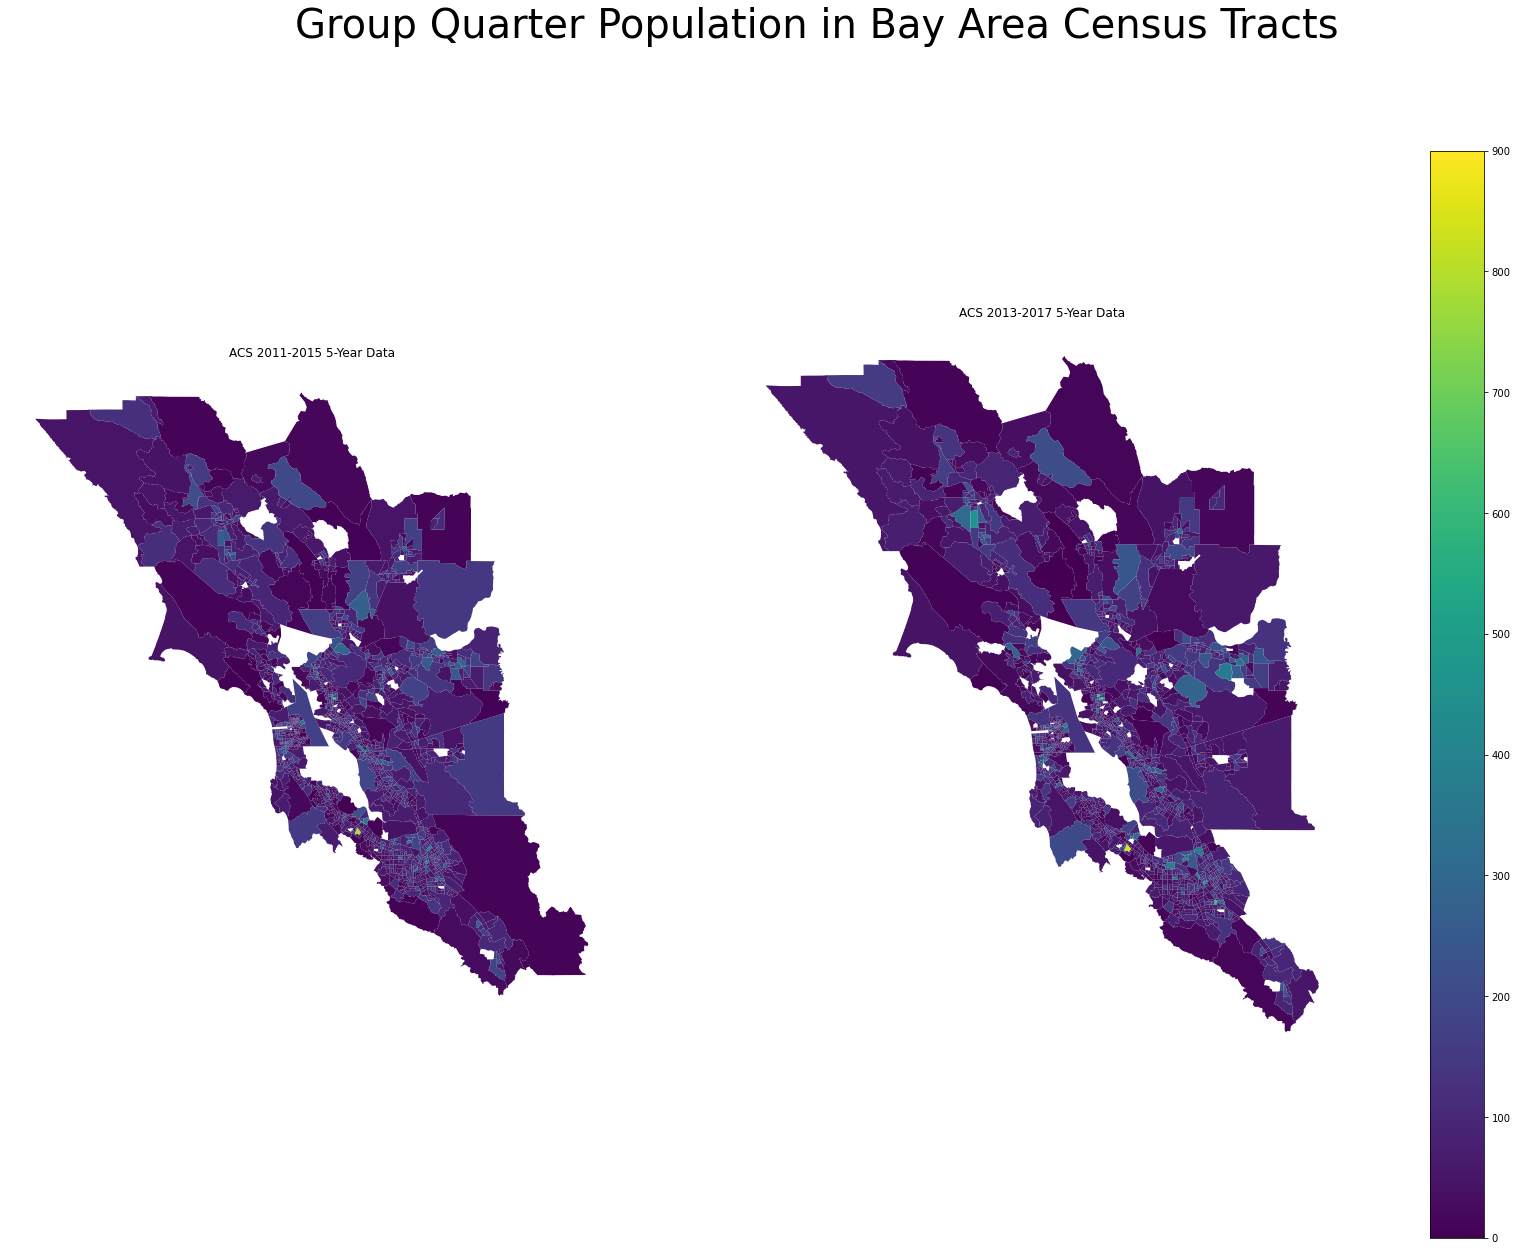

In [102]:
#create side by side maps
# create the colorbar

divnorm = matplotlib.colors.Normalize(vmin=0, vmax=900)
cbar = plt.cm.ScalarMappable(norm=divnorm)

# plot
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Group Quarter Population in Bay Area Census Tracts", fontsize=40)
ax1 = gq_acs5_merge.plot(ax=ax1, column='GQPOP_2015',legend=False, vmax = 900)
ax1.axis('off')
ax1.title.set_text('ACS 2011-2015 5-Year Data')          
ax2 = gq_acs5_merge.plot(ax=ax2, column='GQPOP_2017',legend=False, vmax = 900)
ax2.axis('off')
ax2.title.set_text('ACS 2013-2017 5-Year Data')    

## add colorbar
ax_cbar = fig.colorbar(cbar, ax=(ax1, ax2))


In [103]:
#mapping where 2017 data has more GQPop

#create a new dataframe
gq_acs5_increase = gq_acs5_merge.loc[gq_acs5_merge['GQPOP_diff'] > 0].copy()
gq_acs5_increase.sort_values(by = 'GQPOP_diff', ascending = False).head(10)

GEOID                                           geometry  \
685   06013355108  POLYGON ((-121.83793 37.94225, -121.83789 37.9...   
1352  06085512020  POLYGON ((-121.84175 37.27703, -121.84145 37.2...   
811   06085500200  POLYGON ((-121.91125 37.35418, -121.91083 37.3...   
795   06085508704  POLYGON ((-122.03358 37.37965, -122.03354 37.3...   
1343  06001422400  POLYGON ((-122.27375 37.87779, -122.27369 37.8...   
884   06085504504  POLYGON ((-121.91633 37.42560, -121.91625 37.4...   
1193  06081603900  POLYGON ((-122.42842 37.60658, -122.42838 37.6...   
230   06097153300  POLYGON ((-122.81640 38.40122, -122.81639 38.4...   
270   06097153200  POLYGON ((-122.74159 38.39343, -122.74156 38.3...   
1153  06041115000  POLYGON ((-122.61316 38.01817, -122.61277 38.0...   

      GQPOP_2015  GQPOP_ME_2015  GQPOP_2017  GQPOP_ME_2017  GQPOP_diff  
685         45.0           45.0       369.0          196.0       324.0  
1352       333.0          134.0       617.0          406.0       284.0  
811        132.0           94.0       405.0          224.0       273.0  
795        130.0           77.0       382.0          233.0       252.0  
1343       374.0          171.0       620.0          402.0       246.0  
884        149.0           85.0       380.0          244.0       231.0  
1193        60.0           57.0       282.0          188.0       222.0  
230        109.0           80.0       310.0          185.0       201.0  
270        267.0          148.0       467.0          175.0       200.0  
1153        91.0           65.0       278.0          133.0       187.0

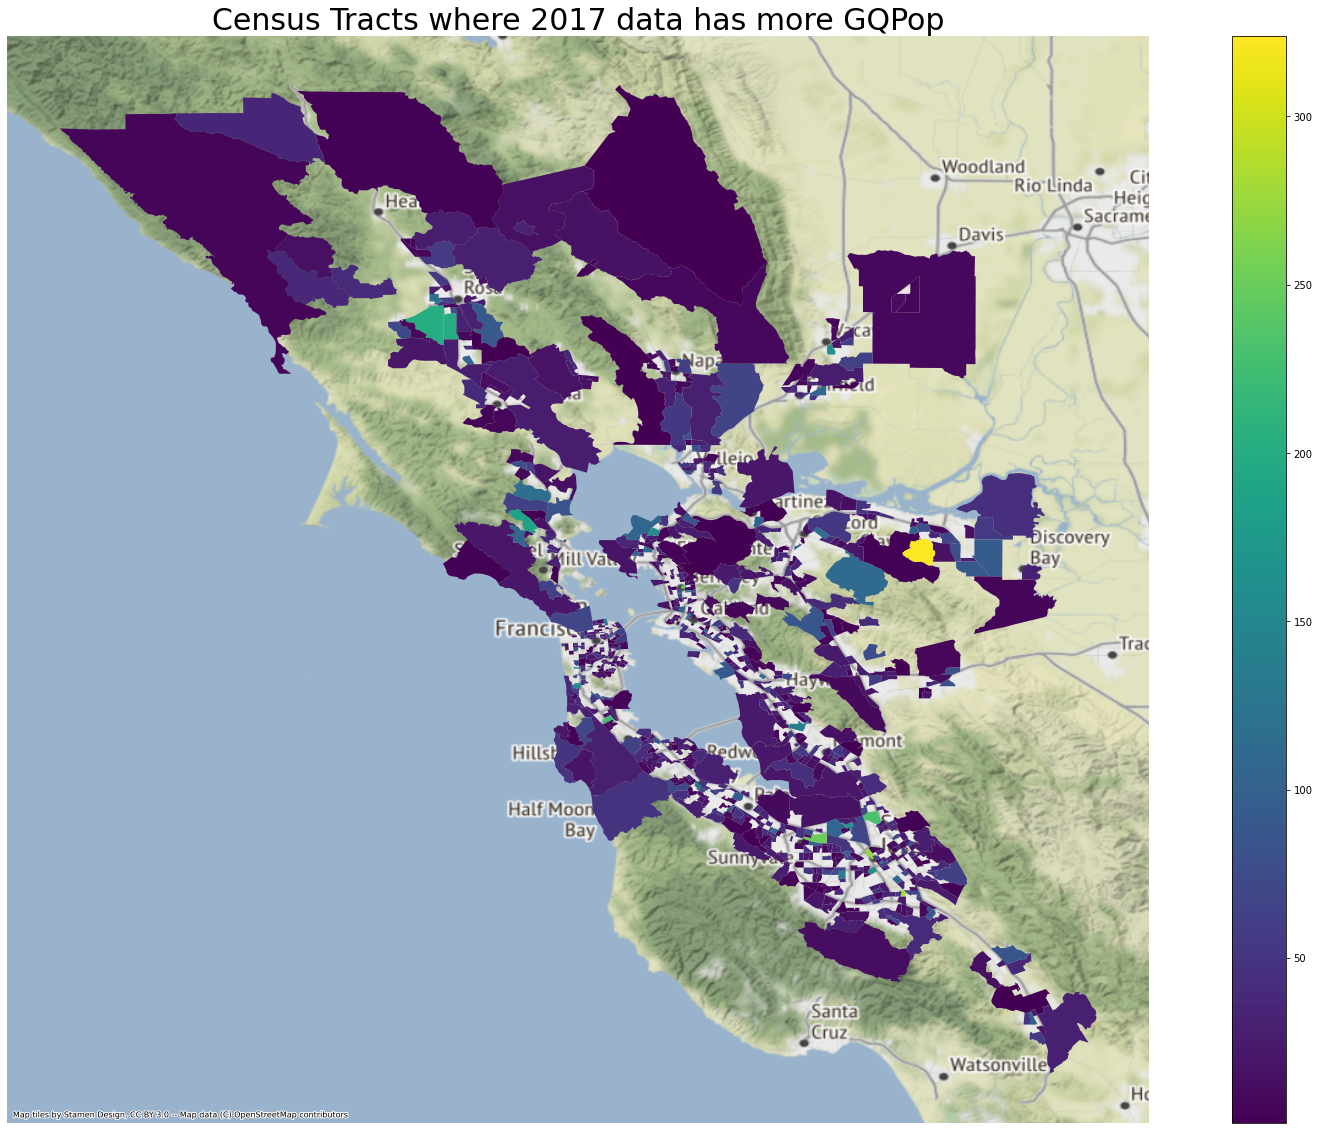

In [104]:
#plot
ax=gq_acs5_increase.plot(column = 'GQPOP_diff', legend = True)
plt.title('Census Tracts where 2017 data has more GQPop', fontsize = 30)
plt.axis('off');
cx.add_basemap(ax, crs=gq_acs5_increase.crs)

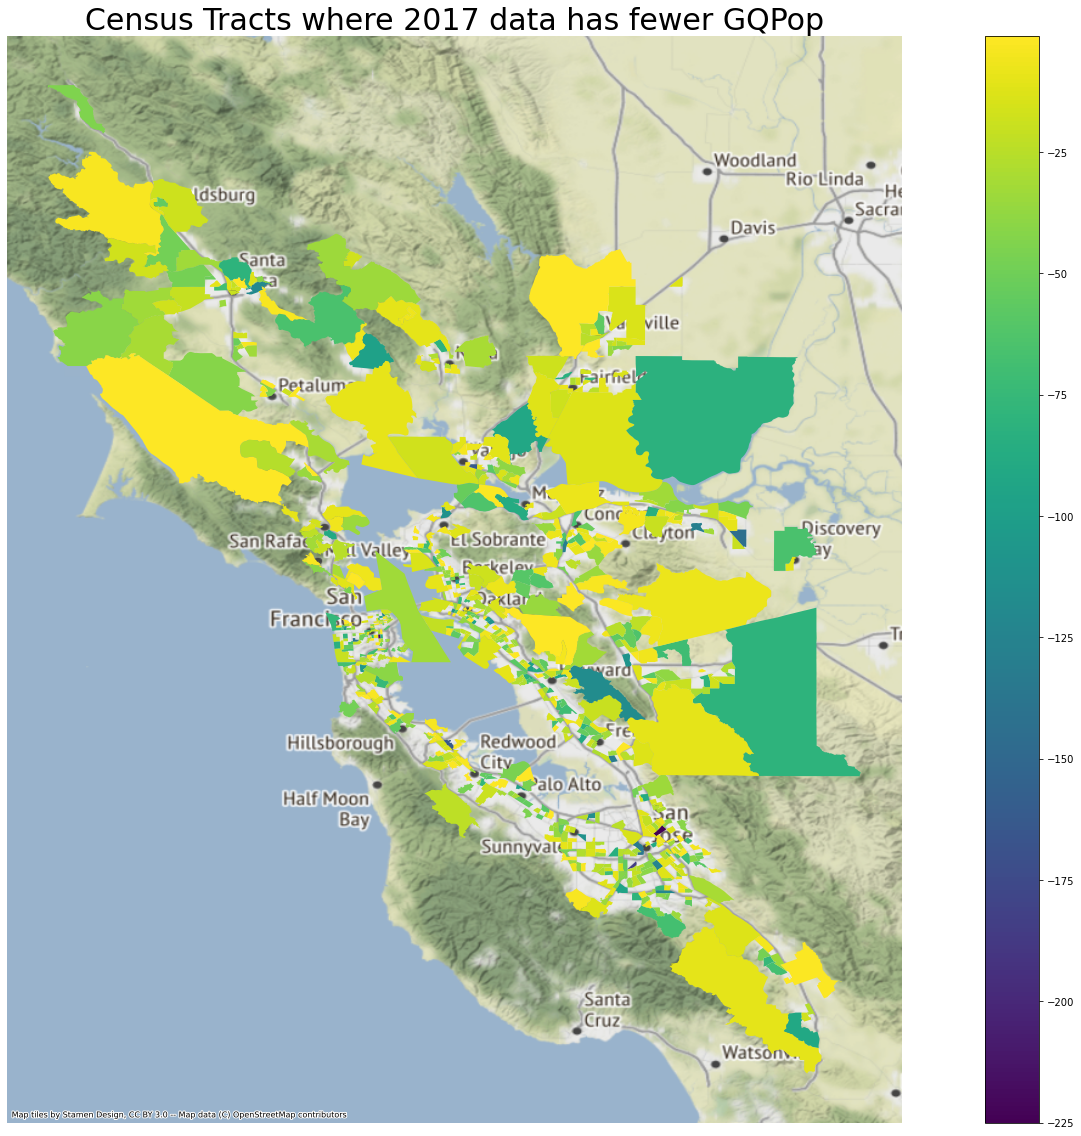

In [105]:
#repeat for where 2017 data has fewer GQ pop
#create a new dataframe
gq_acs5_decrease = gq_acs5_merge.loc[gq_acs5_merge['GQPOP_diff'] < 0].copy()
#plot
ax=gq_acs5_decrease.plot(column = 'GQPOP_diff', legend = True)
plt.title('Census Tracts where 2017 data has fewer GQPop', fontsize = 30)
plt.axis('off');
cx.add_basemap(ax, crs=gq_acs5_decrease.crs)

#### 4.2. Exploring 2020 data

In [106]:
#reading the shapefile
BA_tracts_20 = gpd.read_file('M:/Data/Census/Geography/tl_2020_06_tract/tl_2020_06_tract_bayarea.shp')
BA_tracts_20.head()

STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  MTFCC  \
0      06      085  501402  06085501402  5014.02  Census Tract 5014.02  G5020   
1      06      013  392000  06013392000     3920     Census Tract 3920  G5020   
2      06      013  351200  06013351200     3512     Census Tract 3512  G5020   
3      06      085  508102  06085508102  5081.02  Census Tract 5081.02  G5020   
4      06      085  504505  06085504505  5045.05  Census Tract 5045.05  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S   522620       0  +37.3453341  -121.8665169   
1        S  1028096   23043  +37.9094178  -122.2748795   
2        S  9054683       0  +37.8682136  -122.1047907   
3        S  2723444       0  +37.3303622  -122.0048859   
4        S  1934583       0  +37.4089171  -121.9019654   

                                            geometry  
0  POLYGON ((-121.87381 37.34412, -121.87361 37.3...  
1  POLYGON ((-122.28449 37.91723, -122.28380 37.9...  
2  POLYGON ((-122.12723 37.87558, -122.12721 37.8...  
3  POLYGON ((-122.01437 37.32558, -122.01416 37.3...  
4  POLYGON ((-121.91291 37.41555, -121.91280 37.4...

In [107]:
BA_tracts_20 = BA_tracts_20[['GEOID','geometry']]

In [108]:
gq_2020['GQPOP'] = pd.to_numeric(gq_2020['GQPOP'])
gq_2020['GQPOP_ME'] = pd.to_numeric(gq_2020['GQPOP_ME'])
gq_2020.head()

NAME  GQPOP state county  \
0  Census Tract 3131.02, Contra Costa County, Cal...    307    06    013   
1  Census Tract 3131.04, Contra Costa County, Cal...     15    06    013   
2  Census Tract 3131.05, Contra Costa County, Cal...      6    06    013   
3  Census Tract 3131.06, Contra Costa County, Cal...     22    06    013   
4  Census Tract 3131.07, Contra Costa County, Cal...      0    06    013   

    tract  GQPOP_ME  year  
0  313102         0  2020  
1  313104         0  2020  
2  313105         0  2020  
3  313106         0  2020  
4  313107         0  2020

In [109]:
#remove census tract where GQPOP is less than 1
gq_2020 = gq_2020.loc[gq_2020['GQPOP'] > 1]

In [110]:
gq_2020.GQPOP.max()

8387

In [111]:
#create merge geo_id and merge with shapefile
gq_2020['merge_geoid'] = gq_2020['state'].astype(str)+ gq_2020['county'].astype(str)+ gq_2020['tract'].astype(str)
gq_2020_merge = BA_tracts_20.merge(gq_2020, left_on = 'GEOID', 
                                right_on = 'merge_geoid', how = 'left').drop(['merge_geoid'], axis = 1)
gq_2020_merge.head()

GEOID                                           geometry  \
0  06085501402  POLYGON ((-121.87381 37.34412, -121.87361 37.3...   
1  06013392000  POLYGON ((-122.28449 37.91723, -122.28380 37.9...   
2  06013351200  POLYGON ((-122.12723 37.87558, -122.12721 37.8...   
3  06085508102  POLYGON ((-122.01437 37.32558, -122.01416 37.3...   
4  06085504505  POLYGON ((-121.91291 37.41555, -121.91280 37.4...   

                                                NAME  GQPOP state county  \
0  Census Tract 5014.02, Santa Clara County, Cali...   11.0    06    085   
1                                                NaN    NaN   NaN    NaN   
2  Census Tract 3512, Contra Costa County, Califo...   16.0    06    013   
3  Census Tract 5081.02, Santa Clara County, Cali...   27.0    06    085   
4  Census Tract 5045.05, Santa Clara County, Cali...   15.0    06    085   

    tract  GQPOP_ME    year  
0  501402       0.0  2020.0  
1     NaN       NaN     NaN  
2  351200       0.0  2020.0  
3  508102       0.0  2020.0  
4  504505       0.0  2020.0

In [112]:
gq_2020_merge.describe(include='all')

GEOID                                           geometry  \
count          1772                                               1772   
unique         1772                                               1772   
top     06001983200  POLYGON ((-122.42242 37.790358, -122.422204 37...   
freq              1                                                  1   
mean            NaN                                                NaN   
std             NaN                                                NaN   
min             NaN                                                NaN   
25%             NaN                                                NaN   
50%             NaN                                                NaN   
75%             NaN                                                NaN   
max             NaN                                                NaN   

                                                   NAME        GQPOP state  \
count                                              1347  1347.000000  1347   
unique                                             1347          NaN     1   
top     Census Tract 2523.17, Solano County, California          NaN    06   
freq                                                  1          NaN  1347   
mean                                                NaN   129.807721   NaN   
std                                                 NaN   455.705318   NaN   
min                                                 NaN     2.000000   NaN   
25%                                                 NaN    16.000000   NaN   
50%                                                 NaN    35.000000   NaN   
75%                                                 NaN    91.000000   NaN   
max                                                 NaN  8387.000000   NaN   

       county   tract  GQPOP_ME    year  
count    1347    1347    1347.0  1347.0  
unique      9    1347       NaN     NaN  
top       001  402400       NaN     NaN  
freq      312       1       NaN     NaN  
mean      NaN     NaN       0.0  2020.0  
std       NaN     NaN       0.0     0.0  
min       NaN     NaN       0.0  2020.0  
25%       NaN     NaN       0.0  2020.0  
50%       NaN     NaN       0.0  2020.0  
75%       NaN     NaN       0.0  2020.0  
max       NaN     NaN       0.0  2020.0

##### group quarter maximum looks super weird, let's say where that tract is on the map.

In [113]:
gq_2020_merge.sort_values(by = 'GQPOP', ascending = False).head(20)

GEOID                                           geometry  \
1063  06085513000  POLYGON ((-122.17373 37.42636, -122.17349 37.4...   
151   06001422800  POLYGON ((-122.26599 37.86783, -122.26587 37.8...   
1225  06095253000  POLYGON ((-121.99628 38.32511, -121.99584 38.3...   
801   06001450102  POLYGON ((-121.91057 37.72936, -121.91055 37.7...   
248   06041122000  POLYGON ((-122.49918 37.94228, -122.49891 37.9...   
1554  06085500902  POLYGON ((-121.88393 37.33300, -121.88329 37.3...   
1434  06085511608  POLYGON ((-122.19131 37.42545, -122.19129 37.4...   
385   06097151310  POLYGON ((-122.69853 38.34317, -122.69835 38.3...   
554   06001422700  POLYGON ((-122.25459 37.86932, -122.25456 37.8...   
53    06085505203  POLYGON ((-121.94345 37.35016, -121.94335 37.3...   
1667  06075015701  POLYGON ((-122.45522 37.77760, -122.45433 37.7...   
670   06001401700  POLYGON ((-122.34668 37.81103, -122.34093 37.8...   
570   06001422500  POLYGON ((-122.26575 37.87881, -122.26551 37.8...   
229   06001401300  POLYGON ((-122.27339 37.81272, -122.27320 37.8...   
1672  06075012504  POLYGON ((-122.41387 37.78186, -122.41222 37.7...   
1483  06055201300  POLYGON ((-122.38698 38.39466, -122.37887 38.3...   
146   06001422000  POLYGON ((-122.33264 37.86267, -122.33137 37.8...   
1280  06085504508  POLYGON ((-121.91638 37.42577, -121.91632 37.4...   
219   06001435102  POLYGON ((-122.06694 37.65122, -122.06678 37.6...   
596   06075018000  POLYGON ((-122.41184 37.77114, -122.41128 37.7...   

                                                   NAME   GQPOP state county  \
1063  Census Tract 5130, Santa Clara County, California  8387.0    06    085   
151       Census Tract 4228, Alameda County, California  7441.0    06    001   
1225       Census Tract 2530, Solano County, California  6618.0    06    095   
801    Census Tract 4501.02, Alameda County, California  3506.0    06    001   
248         Census Tract 1220, Marin County, California  3482.0    06    041   
1554  Census Tract 5009.02, Santa Clara County, Cali...  3457.0    06    085   
1434  Census Tract 5116.08, Santa Clara County, Cali...  3128.0    06    085   
385     Census Tract 1513.10, Sonoma County, California  2889.0    06    097   
554       Census Tract 4227, Alameda County, California  2348.0    06    001   
53    Census Tract 5052.03, Santa Clara County, Cali...  2225.0    06    085   
1667  Census Tract 157.01, San Francisco County, Cal...  2214.0    06    075   
670       Census Tract 4017, Alameda County, California  2131.0    06    001   
570       Census Tract 4225, Alameda County, California  1986.0    06    001   
229       Census Tract 4013, Alameda County, California  1701.0    06    001   
1672  Census Tract 125.04, San Francisco County, Cal...  1549.0    06    075   
1483         Census Tract 2013, Napa County, California  1534.0    06    055   
146       Census Tract 4220, Alameda County, California  1533.0    06    001   
1280  Census Tract 5045.08, Santa Clara County, Cali...  1488.0    06    085   
219    Census Tract 4351.02, Alameda County, California  1290.0    06    001   
596   Census Tract 180, San Francisco County, Califo...  1286.0    06    075   

       tract  GQPOP_ME    year  
1063  513000       0.0  2020.0  
151   422800       0.0  2020.0  
1225  253000       0.0  2020.0  
801   450102       0.0  2020.0  
248   122000       0.0  2020.0  
1554  500902       0.0  2020.0  
1434  511608       0.0  2020.0  
385   151310       0.0  2020.0  
554   422700       0.0  2020.0  
53    505203       0.0  2020.0  
1667  015701       0.0  2020.0  
670   401700       0.0  2020.0  
570   422500       0.0  2020.0  
229   401300       0.0  2020.0  
1672  012504       0.0  2020.0  
1483  201300       0.0  2020.0  
146   422000       0.0  2020.0  
1280  504508       0.0  2020.0  
219   435102       0.0  2020.0  
596   018000       0.0  2020.0

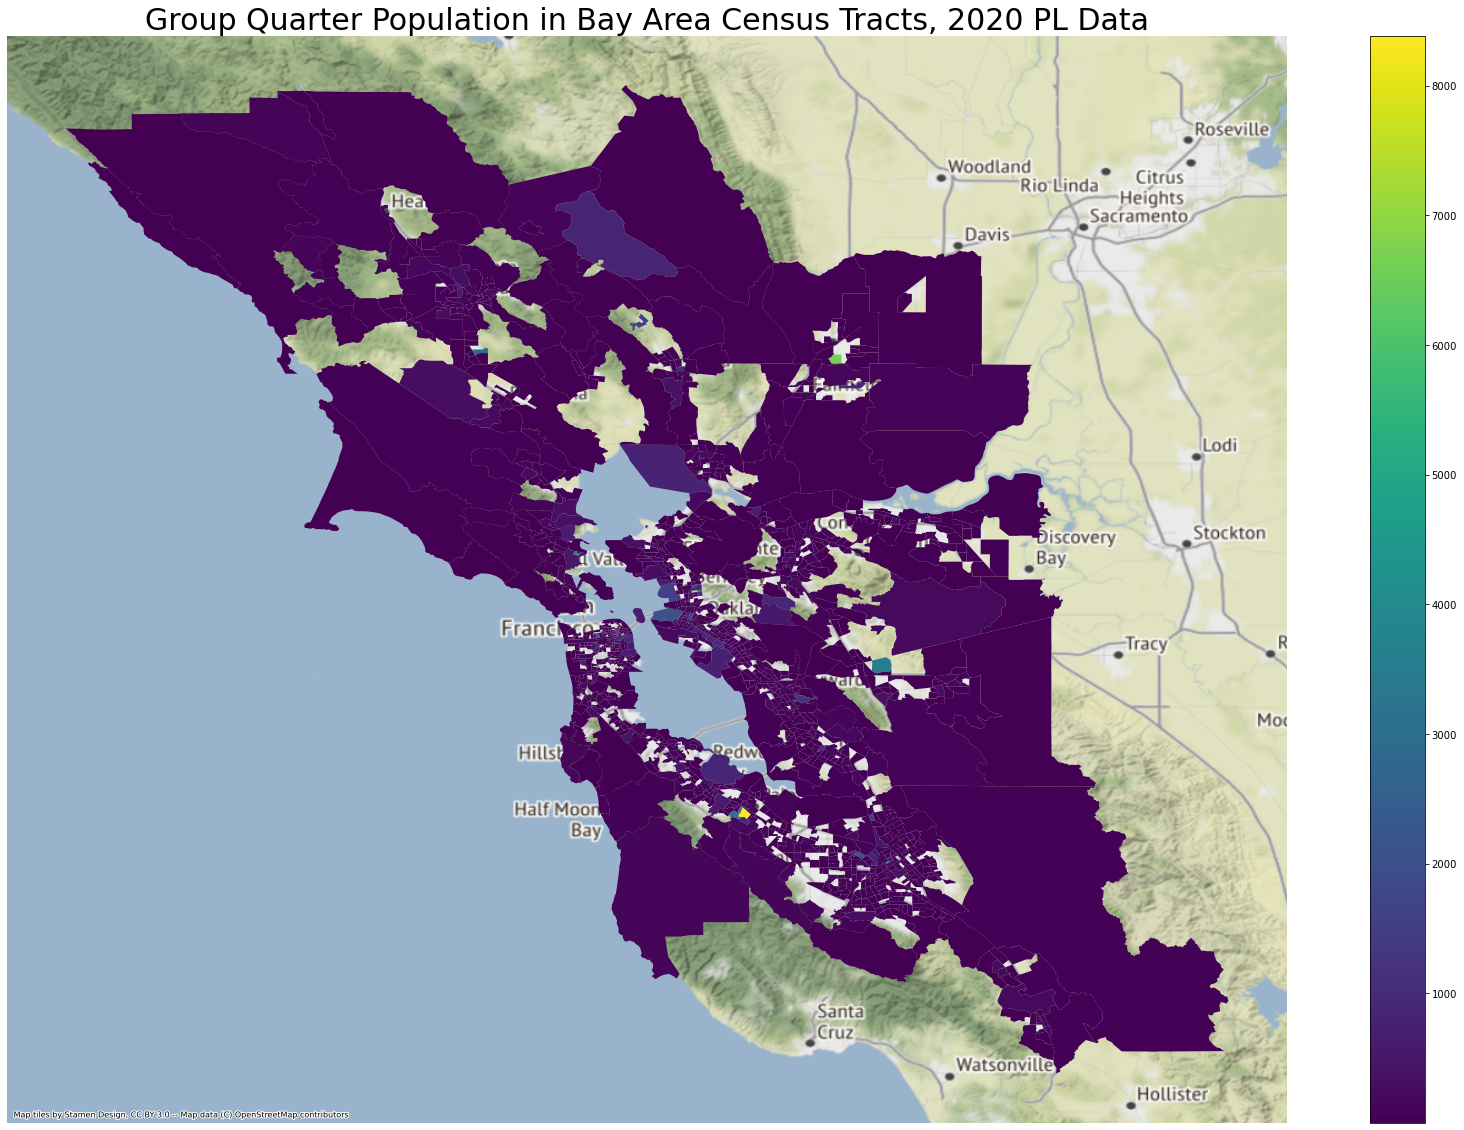

In [114]:
#plot 2015 data individual map
ax=gq_2020_merge.plot(column = 'GQPOP', legend = True)
plt.title('Group Quarter Population in Bay Area Census Tracts, 2020 PL Data', fontsize = 30)
plt.axis('off');
cx.add_basemap(ax, crs=gq_2020_merge.crs)